# Introduction

This is part 2 of a two part 'end-of-phase' project with Flatiron School. In the previous notebook I conducted an descriptive and inferential analysis of the dataset that I will be using in this model creation.

# Recap

In the first notebook I answered many questions both descriptive and inferential about the data within my dataset here. 
I think the question that will be most apparent in this notebook is 'Which Companies Account for the highest amount of Market Capitalization?' I will later use that question first to create a failled model and then to use as the outputs for my working model

## Table of Contents
- [Introduction](#Introduction)
- [Recap](#Recap)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Shotgun Method](#Shotgun-Method)
    - [Advanced Machine Learning: 35 Stocks](#Advanced-Machine-Learning:-35-Stocks)
- [Advanced Machine Learning: Single Stock Futures](#Advanced-Machine-Learning:-Single-Stock-Futures)
- [Creating The Pipeline](#Creating-The-Pipeline)
- [The Final Result](#The-Final-Result)
- [Summary](#Summary)

In [73]:
import nbformat

def generate_toc(notebook_path):
    with open(notebook_path) as f:
        nb = nbformat.read(f, as_version=4)
    
    toc = []
    for cell in nb.cells:
        if cell.cell_type == 'markdown':
            lines = cell.source.split('\n')
            for line in lines:
                if line.startswith('#'):
                    header_level = line.count('#')
                    header_text = line.replace('#', '').strip()
                    toc.append((header_level, header_text))
    
    toc_md = ['## Table of Contents']
    for level, text in toc:
        toc_md.append(f"{'    ' * (level - 1)}- [{text}](#{text.replace(' ', '-')})")
    
    return '\n'.join(toc_md)

notebook_path = 'stock model.ipynb'
toc_md = generate_toc(notebook_path)

# Print the generated TOC
# print(toc_md)

# Data Cleaning and Preprocessing

Lets begin!

Imports

In [1]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import yfinance as yf
from datetime import datetime, timedelta
import warnings
from math import pi
import io
warnings.filterwarnings('ignore')


In [2]:
df_stocks = pd.read_csv('data/sp500_stocks.csv')

Im going to use the data from the S&P 500 dataset simply to get the tickers my model

In [3]:
sp500_tickers = df_stocks['Symbol'].unique()
tickers = []
for x in sp500_tickers:
    tickers.append(x)

Now im using yfinance (yahoo finance api) to collect the data I want to use for shotgun method model prediction

In [4]:
# Keys you're interested in from the 'info' function
keys = ['country', 'sector', 'previousClose', 'overallRisk', 'beta', 'trailingPE', 'forwardPE', 'volume', 'marketCap',
    'enterpriseValue', 'profitMargins', 'sharesOutstanding', 'bookValue', 
    'priceToBook', 'trailingEps', 'forwardEps', 'pegRatio', 'enterpriseToRevenue',
    'enterpriseToEbitda', 'totalCash', 'totalCashPerShare', 'ebitda', 'totalDebt',
    'quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare', 
    'returnOnAssets', 'returnOnEquity', 'freeCashflow', 'operatingCashflow', 
    'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins', 
    'operatingMargins', 'trailingPegRatio'
]


# Empty list to store results
data = []

# Loop through tickers and get the specific info
for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info
    # Extract the values of the keys you're interested in
    row = {key: info.get(key, None) for key in keys}
    data.append(row)

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

In [6]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to both columns and replace the original ones
df['country'] = label_encoder.fit_transform(df['country'])
df['sector'] = label_encoder.fit_transform(df['sector'])


In [7]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Columns to scale
columns_to_scale = ['previousClose', 'overallRisk', 'beta', 'trailingPE', 'forwardPE', 'volume', 'marketCap',
    'enterpriseValue', 'profitMargins', 'sharesOutstanding', 'bookValue', 
    'priceToBook', 'trailingEps', 'forwardEps', 'pegRatio', 'enterpriseToRevenue',
    'enterpriseToEbitda', 'totalCash', 'totalCashPerShare', 'ebitda', 'totalDebt',
    'quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare', 
    'returnOnAssets', 'returnOnEquity', 'freeCashflow', 'operatingCashflow', 
    'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins', 
    'operatingMargins', 'trailingPegRatio'
]

# Apply MinMaxScaler to the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [9]:
df.dropna(inplace=True)

In [10]:
features = df.drop(columns=['previousClose'])

# Shotgun Method

This method is used to create a baseline accuracy from a number of models all at once

In [11]:
X = features
y = df['previousClose']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [13]:
def train_and_evaluate_models(models):
    metrics = {
        'R-squared': r2_score,
        'Mean Squared Error': mean_squared_error,
        'Mean Absolute Error': mean_absolute_error,
        'Explained Variance': explained_variance_score,
        'Root Mean Squared Error': root_mean_squared_error,
        'Mean Absolute Percentage Error': mean_absolute_percentage_error
    }

    results = {}

    for metric_name, metric_function in metrics.items():
        model_scores = {}
        for model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = metric_function(y_test, y_pred)
            model_scores[str(model)] = score
        results[metric_name] = model_scores

    return results

In [14]:
models = [RandomForestRegressor(), LinearRegression(), KNeighborsRegressor()]
model_metrics = train_and_evaluate_models(models=models)

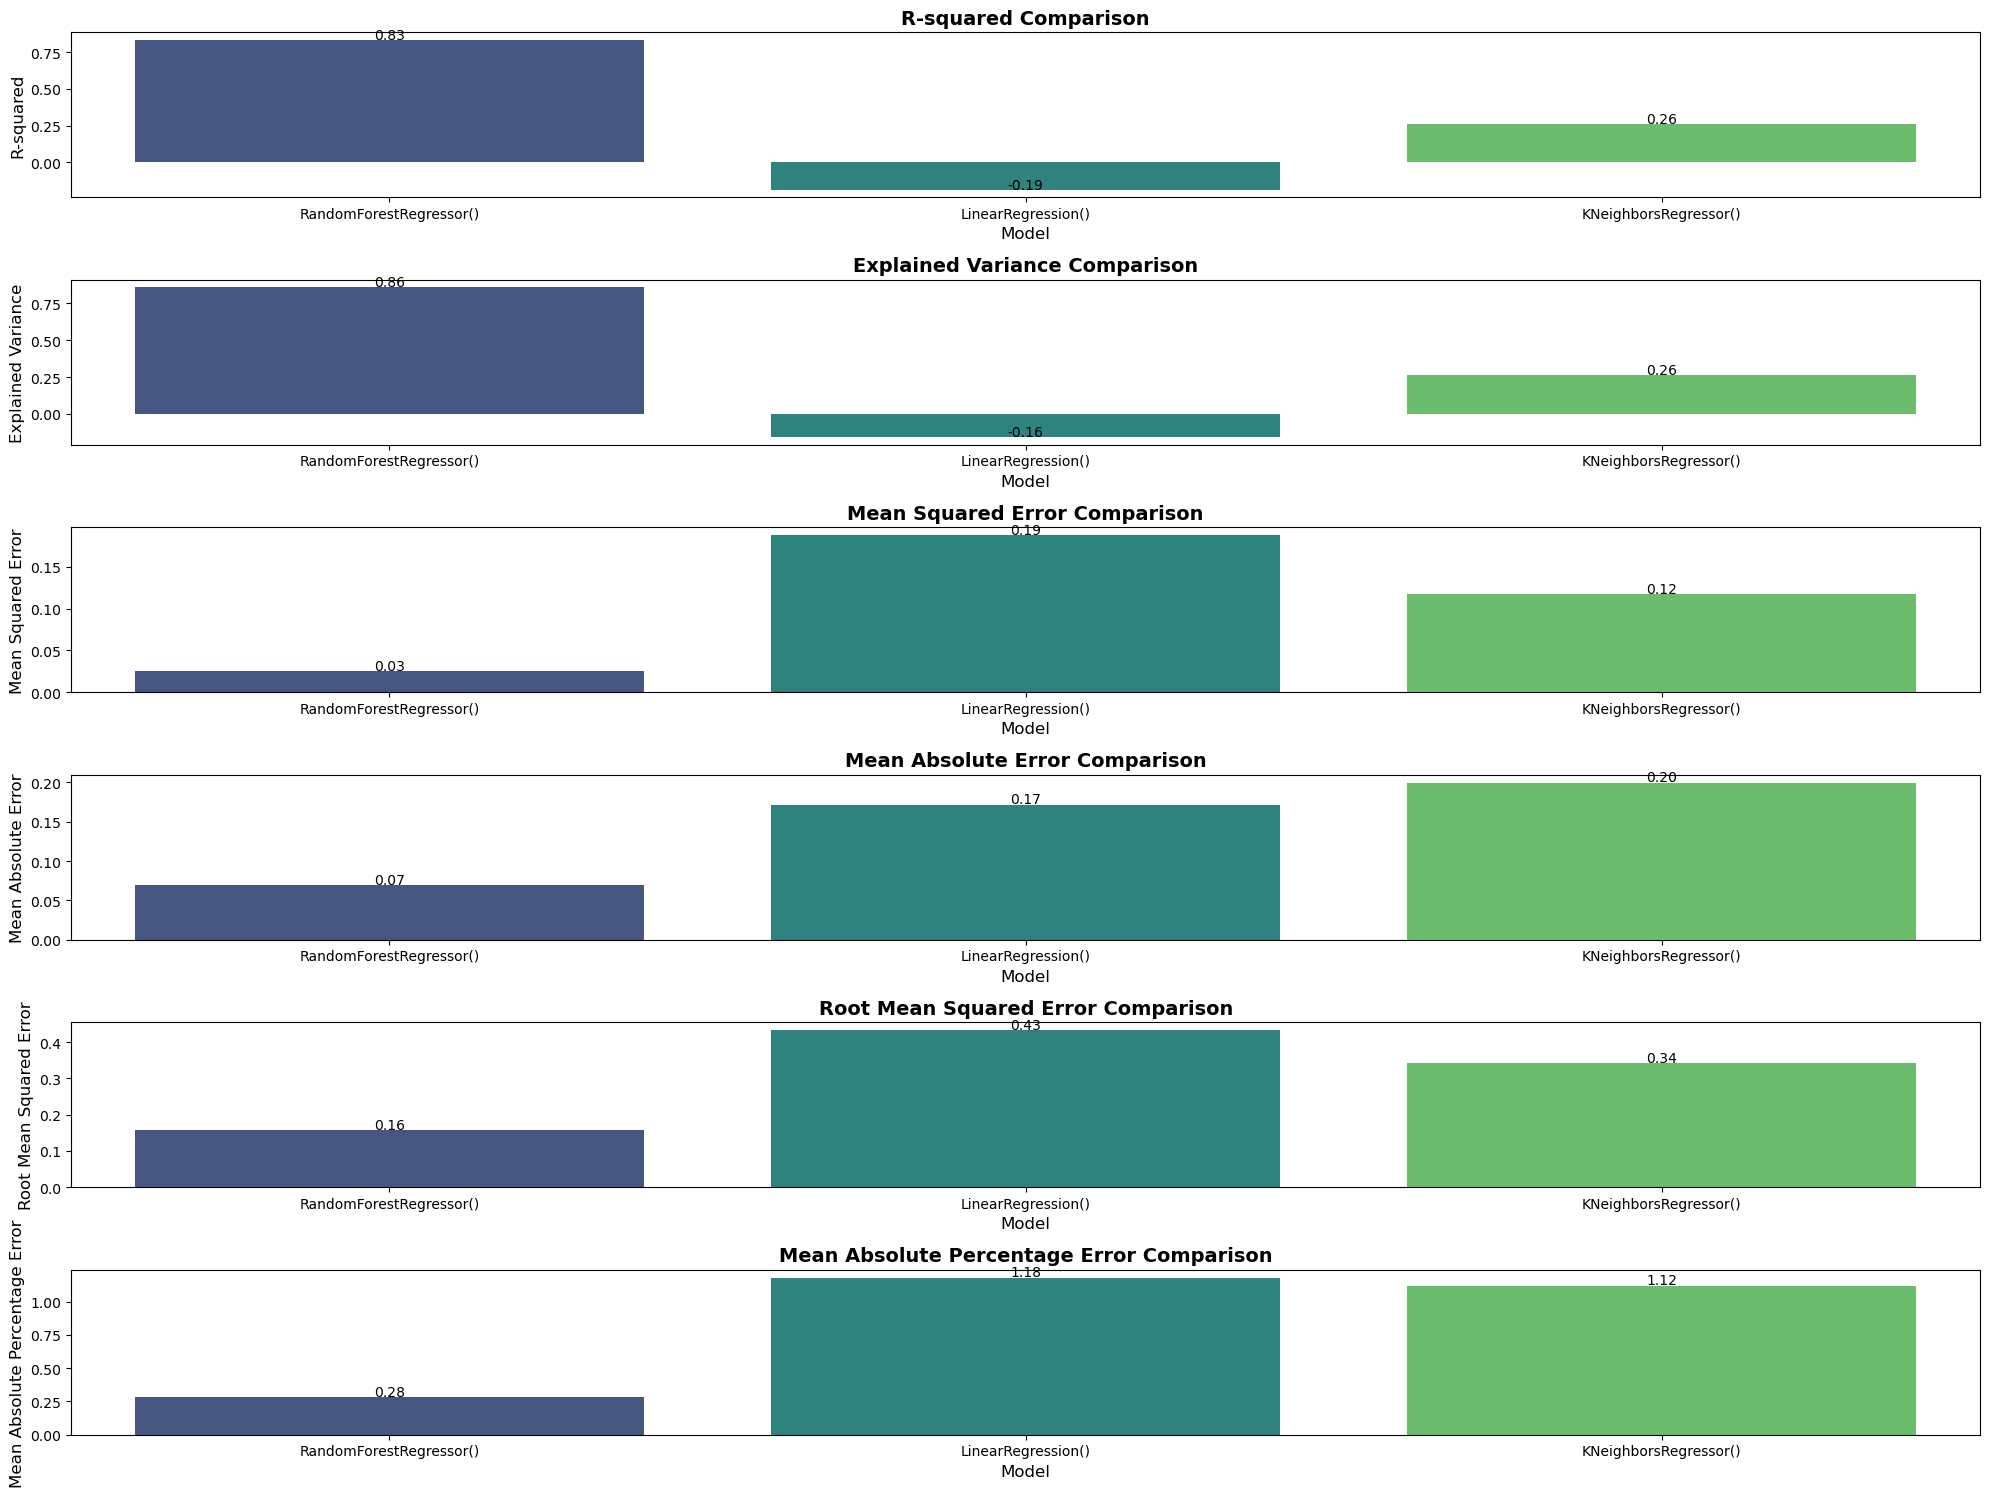

In [15]:
fig, axes = plt.subplots(6, 1, figsize=(20, 15))

# List of metric names for easier iteration
metric_names = ['R-squared', 'Explained Variance', 'Mean Squared Error', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error']

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    model_scores = model_metrics[metric_name]

    sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="viridis", ax=ax)

    # Add labels to the bars
    for j, score in enumerate(model_scores.values()):
        if metric_name == 'R-squared':
            ax.text(j, score + 0.01 *max(model_scores.values()), f'{score:.2f}', ha='center')
        else:
            ax.text(j, score + 0.01 * max(model_scores.values()), f'{score:.2f}', ha='center')

    # Adding labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f'{metric_name} Comparison', fontsize=14, weight='bold')

# Adjust layout to prevent overlapping
plt.tight_layout()
# plt.savefig('savefig/RegressionModels.png')
plt.show()

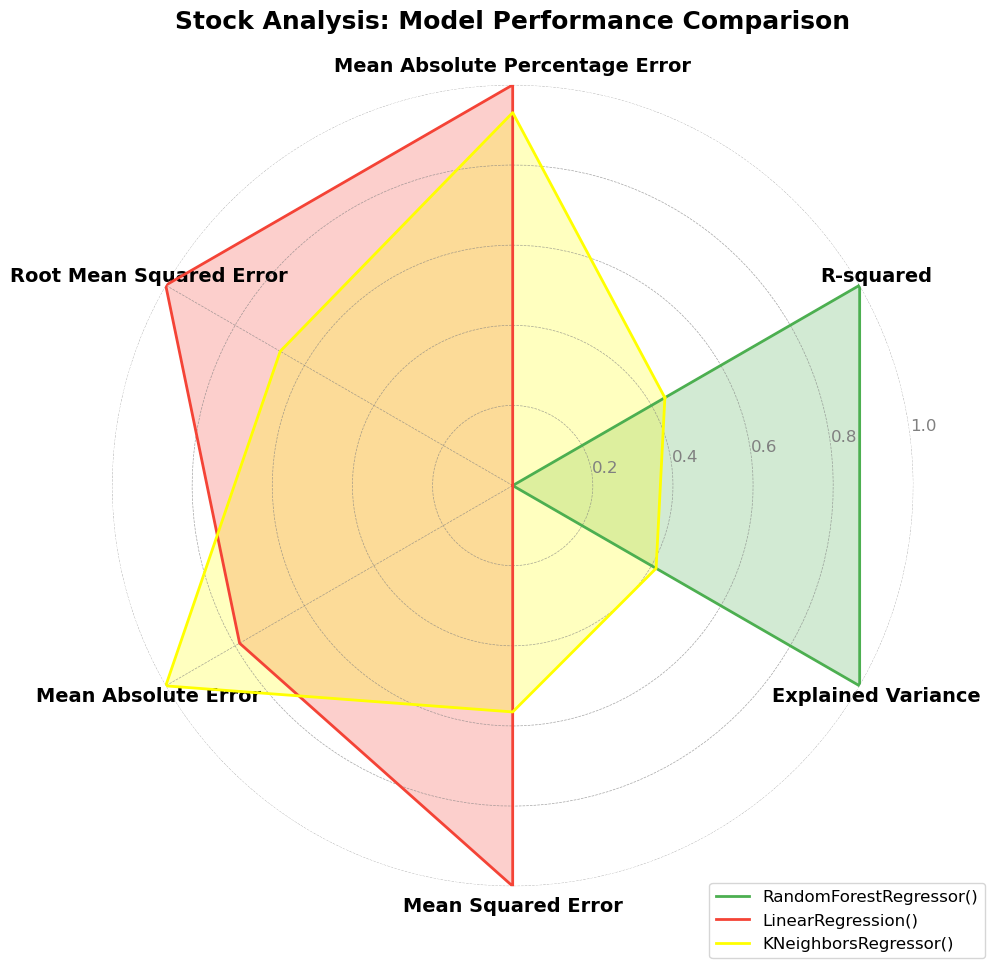

In [16]:
# Reorder the list of metric names so that 'R-squared' and 'Explained Variance' are next to each other
metric_names = ['R-squared', 'Explained Variance', 'Mean Squared Error', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error']

# Prepare the data for radar chart
model_names = list(next(iter(model_metrics.values())).keys())  # Get the list of model names
num_metrics = len(metric_names)

# Initialize a dictionary to hold the scaled values
scaled_model_metrics = {metric: {} for metric in metric_names}

# Apply MinMax scaling for each metric individually across models
scaler = MinMaxScaler()

for metric in metric_names:
    # Extract the scores for this metric across all models
    scores = np.array([model_metrics[metric][model] for model in model_names]).reshape(-1, 1)
    
    # Scale the scores for this metric
    scaled_scores = scaler.fit_transform(scores).flatten()
    
    # Store the scaled scores back into the dictionary
    for i, model in enumerate(model_names):
        scaled_model_metrics[metric][model] = scaled_scores[i]

# Create angles for the radar plot to form a hexagon (6 sides)
angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
angles += angles[:1]  # Complete the loop

# Define the color mapping for each model with exact colors
color_mapping = {
    'RandomForestRegressor()': '#4CAF50',  # Green used previously
    'KNeighborsRegressor()': 'yellow',
    'LinearRegression()': '#F44336'  # Red used previously
}

# Create the radar plot with hexagonal grid
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Customize the hexagonal appearance by manually setting the radial ticks and limits
ax.set_theta_offset(pi / 6)  # Start the first axis at the top of the hexagon
ax.set_theta_direction(-1)   # Ensure the axes go clockwise

# Plot each model's scaled metrics with their assigned colors
for model in model_names:
    scores = [scaled_model_metrics[metric][model] for metric in metric_names]
    scores += scores[:1]  # Complete the loop for radar chart
    
    ax.plot(angles, scores, linewidth=2, linestyle='solid', label=model, color=color_mapping.get(str(model), 'blue'))
    ax.fill(angles, scores, alpha=0.25, color=color_mapping.get(str(model), 'blue'))

# Add labels for each metric at the corresponding angles
plt.xticks(angles[:-1], metric_names, color='black', size=14, weight='bold')

# Set y-ticks and y-limits for better readability (since everything is now scaled between 0 and 1)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['0.2', '0.4', '0.6', '0.8', '1.0'], color="grey", size=12)
plt.ylim(0, 1)

# Customize the grid to have a hexagonal shape
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['polar'].set_visible(False)

# Title and legend
plt.title('Stock Analysis: Model Performance Comparison', size=18, color='black', weight='bold', pad=20)

# Move the legend to the lower-right corner
plt.legend(loc='lower right', bbox_to_anchor=(1.1, -0.1), fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig('shotgun.png', transparent=True)
plt.show()



## Advanced Machine Learning: 35 Stocks

This was the original concept I concieved, the plan was to train the model on 35 different stocks at once and then use that model to predict new data for a stock that wasn't in the original 35, it went just about as well as it sounds

In [71]:
# List of 35 stocks with the highest market cap in respective sector
tickers = ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'ORCL', 'ADBE', 'CRM', 'AMD', 'ACN', # 9 Stocks from the Technology Sector
           'BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', # 6 Stocks from the Financial Services Sector
           'LLY', 'UNH', 'JNJ', 'ABBV', # 4 Stocks from the Healthcare Sector
           'GE', 'CAT', 'RTX', 'UNP', # 4 Stocks from the Industrials Sector
           'AMZN', 'TSLA', 'HD', # 3 Stocks from the Consumer Cyclical Sector
           'GOOGL', 'META', 'NFLX', # 3 Stocks from the Communication Services Sector
           'WMT', 'PG', # 2 Stocks from the Consumer Defensive Sector
           'XOM', # 1 Stock from the Energy Sector
           'PLD', # 1 Stock from the Real Estate Sector
           'NEE', # 1 Stock from the Utilities Sector
           'LIN' # 1 Stock from the Basic Materials Sector
]

In [18]:
# Define the end date as yesterday
end_date = datetime.now() - timedelta(1)
end_date_str = end_date.strftime('%Y-%m-%d')

In [19]:
stock_data = pd.DataFrame()
for ticker in tickers:
    df = yf.download(ticker, start="2014-01-01", end=end_date_str)
    df['Ticker'] = ticker
    stock_data = pd.concat([stock_data, df])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [20]:
# Select and pivot the data
stock_data = stock_data[['Ticker', 'Adj Close']]
stock_data = stock_data.pivot_table(index=stock_data.index, columns='Ticker', values='Adj Close')

In [21]:
# Scaling my data
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(stock_data), columns=stock_data.columns, index=stock_data.index)

In [22]:
# Define time step
time_step = 60

# Create sequences
X_train, y_train = [], []
for i in range(len(scaled_data) - time_step):
    X_train.append(scaled_data.iloc[i:i+time_step].values)
    y_train.append(scaled_data.iloc[i + time_step].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Display the shapes of X_train and y_train
X_train.shape, y_train.shape

((2631, 60, 35), (2631, 35))

In [23]:
num_samples, time_steps, num_stocks = X_train.shape

# Reshape the training data to (num_samples * num_stocks, 1, time_steps, num_features)
X_train_reshaped = X_train.reshape(-1, 1, time_steps)
y_train_reshaped = y_train.reshape(-1)  # Adjust labels accordingly

In [24]:
X_train_reshaped.shape, y_train_reshaped.shape

((92085, 1, 60), (92085,))

In [25]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, time_steps)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0000001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            64400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 200)           160800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1, 200)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 200)           240800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 200)            0

i commented the fitting of my model as the best model has been saved and I wont accidentally spend the time retraining it

In [26]:
# # Early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model with the checkpoint
# history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=10, validation_split=0.2, shuffle=False, callbacks=[early_stop])

In [27]:
# model.save('best_model.h5')

In [28]:
model= load_model('best_model.h5')

In [29]:
def stock_prediction(test_ticker):
    # Load test stock data
    test_stock = pd.DataFrame()
    df = yf.download(test_ticker, start="2014-01-01", end=end_date_str)
    df['Ticker'] = test_ticker
    test_stock = pd.concat([test_stock, df])

    # Select and pivot the test data
    test_stock = test_stock[['Ticker', 'Adj Close']]
    test_stock = test_stock.pivot_table(index=test_stock.index, columns='Ticker', values='Adj Close')

    # Scaling the test data
    scaler = MinMaxScaler()
    scaled_test_data = pd.DataFrame(scaler.fit_transform(test_stock), columns=test_stock.columns, index=test_stock.index)

    # Create sequences
    X_test, y_test = [], []
    for i in range(len(scaled_test_data) - time_step):
        X_test.append(scaled_test_data.iloc[i:i + time_step].values)
        y_test.append(scaled_test_data.iloc[i + time_step].values)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Reshape the test data
    X_test_reshaped = X_test.reshape(-1, 1, time_step)
    y_test_reshaped = y_test.reshape(-1)

    # Make predictions
    predictions = model.predict(X_test_reshaped)

    # Plot the predictions vs actual stock prices starting from the 2000th sample
    plt.plot(y_test_reshaped[2455:], label='Actual Stock Prices')
    plt.plot(predictions[2455:], label='Predicted Stock Prices', linestyle='--')
    plt.legend()
    plt.title(f'Stock Price Prediction vs Actual for {test_ticker}')
    plt.show()

[*********************100%***********************]  1 of 1 completed


83/83 [==============================] - 2s 2ms/step


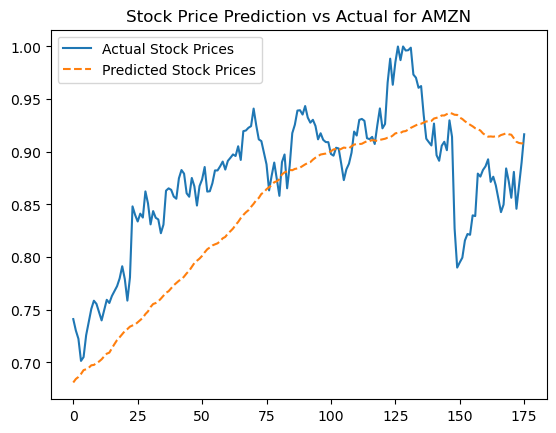

In [30]:
stock_prediction('AMZN')

as you can see, the results were not good

____________

# Advanced Machine Learning: Single Stock Futures

In [31]:
# Define the end date as yesterday
end_date = datetime.now() - timedelta(1)
end_date_str = end_date.strftime('%Y-%m-%d')

In [32]:
# Define the start date as a year before yesterday
start_date = end_date - timedelta(1825)
start_date_str = start_date.strftime('%Y-%m-%d')

In [33]:
# Download stock data
stock_data = yf.download('WM', start=start_date_str, end=end_date_str)

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

[*********************100%***********************]  1 of 1 completed


In [34]:
time_step = 7

In [35]:
# Define the model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 64)             16896     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 91,265
Trainable params: 91,265
Non-trainable params: 0
__________________________________________________

In [38]:
# Step 1: Predict today’s data
todays_data = scaled_data[-time_step:].reshape(1, time_step, 1)
todays_prediction = model.predict(todays_data)
todays_prediction_inversed = scaler.inverse_transform(todays_prediction)
todays_prediction_inversed

1/1 [==============================] - 1s 1s/step


array([[150.05959]], dtype=float32)

In [39]:
# Step 2: Append today’s prediction to the dataset
new_data_point = np.append(stock_data['Close'].values, todays_prediction_inversed)

# Recreate scaled_data based on the updated dataset
updated_scaled_data = scaler.fit_transform(new_data_point.reshape(-1, 1))

In [40]:
# Recreate X and y with the updated dataset
X_new, y_new = [], []
for i in range(len(updated_scaled_data) - time_step - 1):
    X_new.append(updated_scaled_data[i:(i + time_step), 0])  # Add time_step-length sequences to X
    y_new.append(updated_scaled_data[i + time_step, 0])      # Add the next value to y

X_new = np.array(X_new)
y_new = np.array(y_new)
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

In [42]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reducer callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1)

# Train the model with the checkpoint
history = model.fit(X_new, y_new, epochs=100, batch_size=10, validation_split=0.2, shuffle=False, callbacks=[early_stop, reduce_lr])

Epoch 1/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0017 - lr: 1.0000e-06
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0030 - val_loss: 0.0017 - lr: 1.0000e-06
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.0017 - lr: 1.0000e-06
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0016 - lr: 1.0000e-06
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0030 - val_loss: 0.0016 - lr: 1.0000e-06
Epoch 6/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
100/100 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0016 - lr: 1.0000e-06
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0016 - lr: 1.0000e-07
Epoch 8/100
100/100 [==========

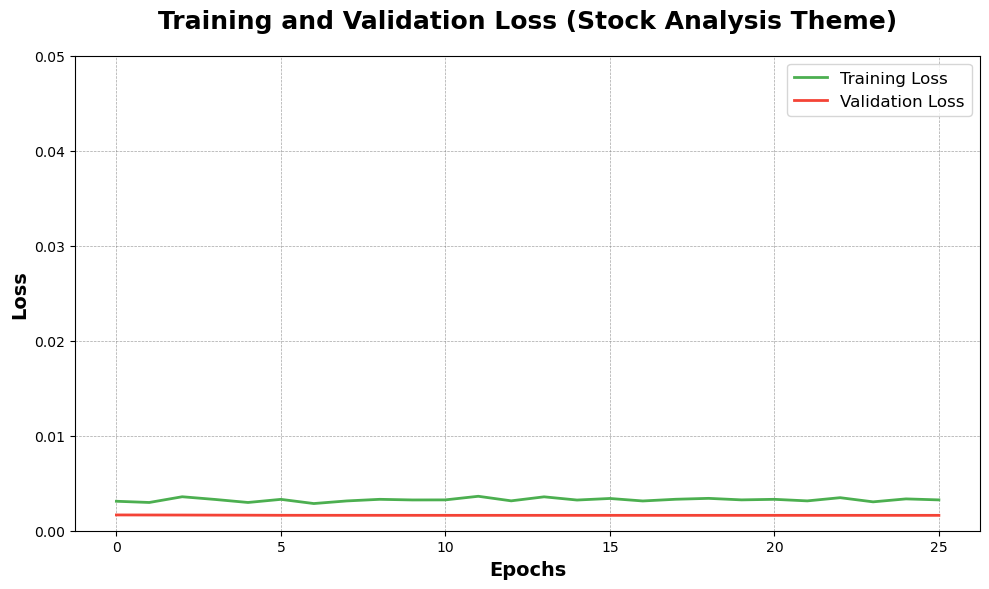

In [64]:
# Plot the training loss and validation loss with stock analysis theme
plt.figure(figsize=(10, 6))

# Plot training loss in green (typically for "positive" improvement)
plt.plot(history.history['loss'], label='Training Loss', color='#4CAF50', linewidth=2)

# Plot validation loss in red (for validation, possibly showing "issues")
plt.plot(history.history['val_loss'], label='Validation Loss', color='#F44336', linewidth=2)

# Set title and labels
plt.title('Training and Validation Loss (Stock Analysis Theme)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Epochs', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')

# Set y-axis limits from 0 to 0.05 as requested
plt.ylim(0, 0.05)

# Add grid lines for better readability
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the legend and display it in the lower right corner
plt.legend(loc='upper right', fontsize=12)

# Clean and polished layout
plt.tight_layout()

# Show the plot
plt.savefig('Loss.png', transparent= True)
plt.show()



In [45]:
# Make new predictions after retraining
predictions = model.predict(X_new)
predictions = scaler.inverse_transform(predictions)
print(f'Predicted Close: {predictions[-1:]}')
print(f"Actual Close: {stock_data['Close'][-1:].values}")

40/40 [==============================] - 0s 7ms/step
Predicted Close: [[207.55775]]
Actual Close: [207.63999939]


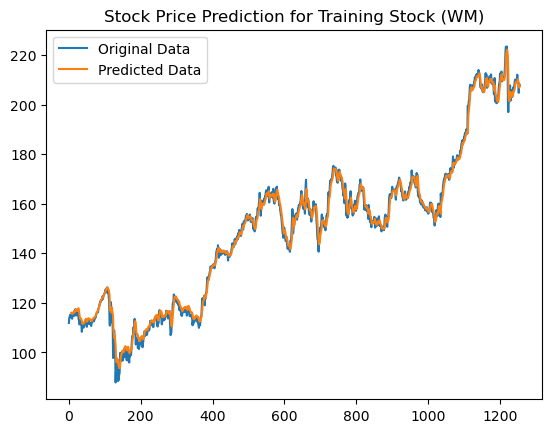

In [66]:
# Collect data for the plot
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions.reshape(-1)

# Create the plot
fig, ax = plt.subplots()
ax.plot(original_data, label='Original Data')
ax.plot(predicted_data, label='Predicted Data')
ax.legend()

plt.title(f"Stock Price Prediction for Training Stock (WM)")
plt.show()

In [47]:
# Initialize the data with the last `time_step` days from the initial_data
initial_data = scaled_data[-7:]
current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
all_predictions = []

for i in range(30):
    # Reshape current_window to match the model input shape (assuming a 3D input for LSTM)
    X_input = current_window.reshape((1, time_step, current_window.shape[1]))

    # Generate multiple predictions (ensemble) for the current day
    ensemble_predictions = []
    for _ in range(15):
        predicted_value = model.predict(X_input)[0][0]  # Assuming a single output per prediction
        ensemble_predictions.append(predicted_value)

    # Calculate the mean of the ensemble predictions
    predicted_value = np.mean(ensemble_predictions)

    # Append the prediction to the list of predictions
    all_predictions.append(predicted_value)

    # Update the current window with the new predicted value
    # We assume here that we're predicting a single feature, like the "Close" price
    predicted_value_as_array = np.array([[predicted_value]])
    current_window = np.vstack([current_window[1:], predicted_value_as_array])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


In [48]:
# Convert predictions back to original scale (if using a scaler)
predicted_prices = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Optionally: Plot or use these predictions as needed
print("Predicted Prices for the next 14 days (using ensemble averaging):", predicted_prices)

Predicted Prices for the next 14 days (using ensemble averaging): [[207.48682]
 [207.3095 ]
 [207.07431]
 [206.83226]
 [206.71588]
 [206.52821]
 [206.34254]
 [206.16513]
 [205.98631]
 [205.80681]
 [205.62862]
 [205.45323]
 [205.27734]
 [205.10245]
 [204.92851]
 [204.75526]
 [204.58284]
 [204.41116]
 [204.24028]
 [204.07016]
 [203.9008 ]
 [203.73218]
 [203.5643 ]
 [203.39711]
 [203.23068]
 [203.06493]
 [202.8999 ]
 [202.73557]
 [202.57193]
 [202.40897]]


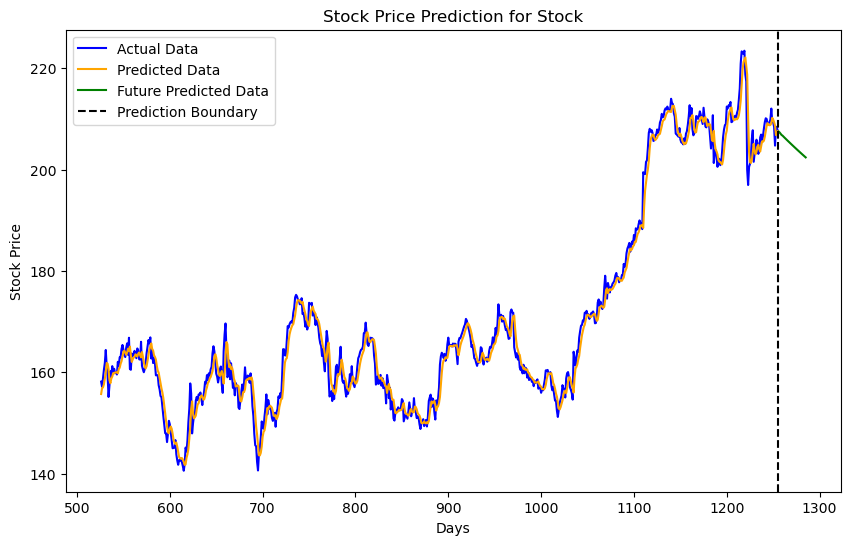

In [49]:
# Number of days to zoom in on
zoom_days = 730

# Create a timeline for the final `zoom_days` of the actual data and original predictions
days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline

plt.figure(figsize=(10, 6))

# Plot last `zoom_days` of actual data in blue
plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue')

# Plot last `zoom_days` of original predictions in orange
plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange')

# Plot future predictions in green after the dotted line
plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='green')

# Add a vertical dotted line at the point where the future predictions start
plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for Stock')

# Show legend
plt.legend()

# Show plot
plt.show()

In [50]:
noise_factor = 0.02  # Adjust this factor to control the level of noise
initial_data = scaled_data[-7:]
current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
noisy_predictions = []

for i in range(30):
    X_input = current_window.reshape((1, time_step, current_window.shape[1]))

    ensemble_predictions = []
    for _ in range(15):
        predicted_value = model.predict(X_input)[0][0]
        ensemble_predictions.append(predicted_value)

    # Calculate the mean of the ensemble predictions
    predicted_value = np.mean(ensemble_predictions)

    # Add random noise to introduce variance
    predicted_value += noise_factor * np.random.randn()

    noisy_predictions.append(predicted_value)

    predicted_value_as_array = np.array([[predicted_value]])
    current_window = np.vstack([current_window[1:], predicted_value_as_array])

1/1 [==============================] - 0s 29ms/step


In [51]:
# Convert predictions back to original scale (if using a scaler)
predicted_prices = scaler.inverse_transform(np.array(noisy_predictions).reshape(-1, 1))

# Optionally: Plot or use these predictions as needed
print("Predicted Prices for the next 14 days (using ensemble averaging):", predicted_prices)

Predicted Prices for the next 14 days (using ensemble averaging): [[207.25578781]
 [205.09259941]
 [207.44677566]
 [204.86040555]
 [206.37385839]
 [203.78016741]
 [204.34877426]
 [203.06496152]
 [201.91924318]
 [202.57627634]
 [204.4023211 ]
 [204.82491294]
 [203.20871656]
 [202.91217971]
 [202.91319764]
 [202.69806045]
 [204.40343129]
 [202.3974059 ]
 [201.7737998 ]
 [201.29047349]
 [202.35854232]
 [201.09411329]
 [204.47733212]
 [201.45977568]
 [200.93608523]
 [198.72822307]
 [198.64837342]
 [197.6346516 ]
 [197.85284041]
 [199.90071274]]


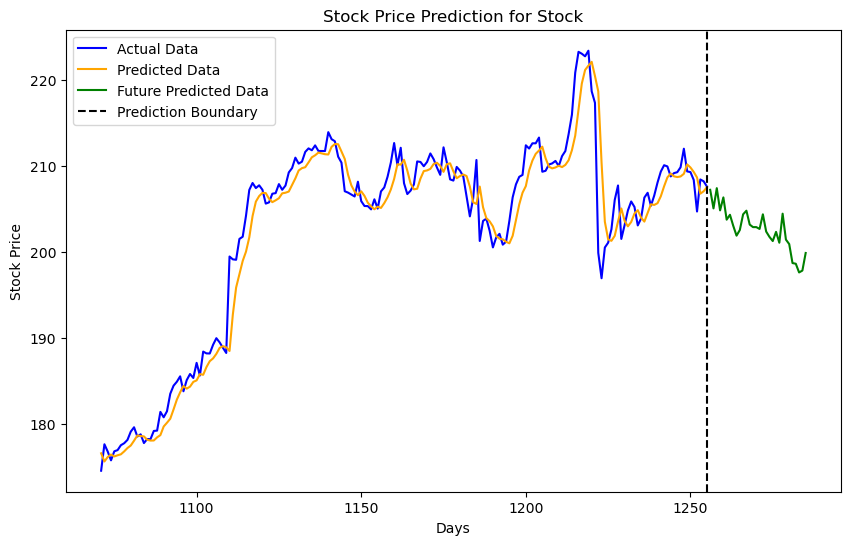

In [52]:
# Number of days to zoom in on
zoom_days = 185

# Create a timeline for the final `zoom_days` of the actual data and original predictions
days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline

plt.figure(figsize=(10, 6))

# Plot last `zoom_days` of actual data in blue
plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue')

# Plot last `zoom_days` of original predictions in orange
plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange')

# Plot future predictions in green after the dotted line
plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='green')

# Add a vertical dotted line at the point where the future predictions start
plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for Stock')

# Show legend
plt.legend()

# Show plot
plt.show()

This process on the otherhand came out REALLY WELL!!

_____________________

# Creating The Pipeline

now that I know my model works and it is performing successfully, i combined all the steps into 1 function

In [67]:
def pipeline(ticker):
    # Define the end date as yesterday
    end_date = datetime.now() - timedelta(1)
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define the start date as 5 years before yesterday
    start_date = end_date - timedelta(1825)
    start_date_str = start_date.strftime('%Y-%m-%d')

    # Define the directory path
    directory = f'Stock Graphs/{ticker}'

    # Check if the directory exists, and create it if it doesn't
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Download stock data
    stock_data = yf.download(ticker, start=start_date_str, end=end_date_str)

    # Scaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

    time_step = 7

    # Define the model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=64))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Step 1: Predict today’s data
    todays_data = scaled_data[-time_step:].reshape(1, time_step, 1)
    todays_prediction = model.predict(todays_data)
    todays_prediction_inversed = scaler.inverse_transform(todays_prediction)
    todays_prediction_inversed

    # Step 2: Append today’s prediction to the dataset
    new_data_point = np.append(stock_data['Close'].values, todays_prediction_inversed)

    # Recreate scaled_data based on the updated dataset
    updated_scaled_data = scaler.fit_transform(new_data_point.reshape(-1, 1))

    # Recreate X and y with the updated dataset
    X_new, y_new = [], []
    for i in range(len(updated_scaled_data) - time_step - 1):
        X_new.append(updated_scaled_data[i:(i + time_step), 0])  # Add time_step-length sequences to X
        y_new.append(updated_scaled_data[i + time_step, 0])      # Add the next value to y

    X_new = np.array(X_new)
    y_new = np.array(y_new)
    X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Learning rate reducer callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1)

    # Train the model with the checkpoint
    model.fit(X_new, y_new, epochs=100, batch_size=10, validation_split=0.2, shuffle=False, callbacks=[early_stop, reduce_lr])

    # Make new predictions after retraining
    predictions = model.predict(X_new)
    predictions = scaler.inverse_transform(predictions)
    print(f'Predicted Close: {predictions[-1:]}')
    print(f"Actual Close: {stock_data['Close'][-1:].values}")

    # Collect data for the plot
    original_data = stock_data['Close'].values
    predicted_data = np.empty_like(original_data)
    predicted_data[:] = np.nan
    predicted_data[-len(predictions):] = predictions.reshape(-1)

    # Historical data plot with prediction
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(original_data, label='Original Data', color='blue', linewidth=2)
    ax.plot(predicted_data, label='Predicted Data', color='orange', linewidth=2)

    # Add labels and title with bold, larger fonts
    ax.set_title(f'Stock Price Prediction for {ticker}', fontsize=18, weight='bold', pad=20)
    ax.set_xlabel('Days', fontsize=14, weight='bold')
    ax.set_ylabel('Stock Price', fontsize=14, weight='bold')

    # Add a grid and legend
    ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='lower right', fontsize=12)

    plt.savefig(f'{directory}/historical.png')
    plt.close()

    # Initialize the data with the last `time_step` days from the initial_data
    initial_data = scaled_data[-7:]
    current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
    all_predictions = []

    for i in range(30):
        # Reshape current_window to match the model input shape (assuming a 3D input for LSTM)
        X_input = current_window.reshape((1, time_step, current_window.shape[1]))

        # Generate multiple predictions (ensemble) for the current day
        ensemble_predictions = []
        for _ in range(15):
            predicted_value = model.predict(X_input)[0][0]  # Assuming a single output per prediction
            ensemble_predictions.append(predicted_value)

        # Calculate the mean of the ensemble predictions
        predicted_value = np.mean(ensemble_predictions)

        # Append the prediction to the list of predictions
        all_predictions.append(predicted_value)

        # Update the current window with the new predicted value
        # We assume here that we're predicting a single feature, like the "Close" price
        predicted_value_as_array = np.array([[predicted_value]])
        current_window = np.vstack([current_window[1:], predicted_value_as_array])

    # Convert predictions back to original scale (if using a scaler)
    predicted_prices = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

    # Number of days to zoom in on
    zoom_days = 730

    # Create a timeline for the final `zoom_days` of the actual data and original predictions
    days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
    predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
    future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline


    # Future predictions plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue', linewidth=2)
    plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange', linewidth=2)
    plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='#4CAF50', linewidth=2)  # Green color for future predictions

    # Add a vertical dotted line at the point where the future predictions start
    plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

    # Add labels and title with bold fonts
    plt.title(f'Stock Price Prediction for {ticker}', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Days', fontsize=14, weight='bold')
    plt.ylabel('Stock Price', fontsize=14, weight='bold')

    # Add grid and legend
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower right', fontsize=12)

    plt.savefig(f'{directory}/future.png')
    plt.close()

    noise_factor = 0.02  # Adjust this factor to control the level of noise
    initial_data = scaled_data[-7:]
    current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
    noisy_predictions = []

    for i in range(30):
        X_input = current_window.reshape((1, time_step, current_window.shape[1]))

        ensemble_predictions = []
        for _ in range(15):
            predicted_value = model.predict(X_input)[0][0]
            ensemble_predictions.append(predicted_value)

        # Calculate the mean of the ensemble predictions
        predicted_value = np.mean(ensemble_predictions)

        # Add random noise to introduce variance
        predicted_value += noise_factor * np.random.randn()

        noisy_predictions.append(predicted_value)

        predicted_value_as_array = np.array([[predicted_value]])
        current_window = np.vstack([current_window[1:], predicted_value_as_array])

    # Convert predictions back to original scale (if using a scaler)
    predicted_prices = scaler.inverse_transform(np.array(noisy_predictions).reshape(-1, 1))

    # Number of days to zoom in on
    zoom_days = 185

    # Create a timeline for the final `zoom_days` of the actual data and original predictions
    days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
    predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
    future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline

    # Noisy future predictions plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue', linewidth=2)
    plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange', linewidth=2)
    plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='#4CAF50', linewidth=2)  # Green color for future predictions

    # Add a vertical dotted line at the point where the future predictions start
    plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

    # Add labels and title with bold fonts
    plt.title(f'Future Stock Price Prediction for {ticker}', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Days', fontsize=14, weight='bold')
    plt.ylabel('Stock Price', fontsize=14, weight='bold')

    # Add grid and legend
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower right', fontsize=12)

    plt.savefig(f'{directory}/noisy_future.png')
    plt.close()

testing the function

In [68]:
#test
pipeline('WM')

[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 22ms/step - loss: 0.0206 - val_loss: 0.0394 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0094 - val_loss: 0.0088 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0054 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0066 - val_loss: 0.0046 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0077 - val_loss: 0.0047 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0071 - val_loss: 0.0036 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0066 - val_loss: 0.0035 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0071 - val_loss: 0.0034 - lr: 0.0010
Epoch 9/100
100/100 [=========

IT WORKS!!!

_________

# The Final Result

In [69]:
# List of 35 stocks with the highest market cap in respective sector
tickers = ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'ORCL', 'ADBE', 'CRM', 'AMD', 'ACN', # 9 Stocks from the Technology Sector
           'BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', # 6 Stocks from the Financial Services Sector
           'LLY', 'UNH', 'JNJ', 'ABBV', # 4 Stocks from the Healthcare Sector
           'GE', 'CAT', 'RTX', 'UNP', # 4 Stocks from the Industrials Sector
           'AMZN', 'TSLA', 'HD', # 3 Stocks from the Consumer Cyclical Sector
           'GOOGL', 'META', 'NFLX', # 3 Stocks from the Communication Services Sector
           'WMT', 'PG', # 2 Stocks from the Consumer Defensive Sector
           'XOM', # 1 Stock from the Energy Sector
           'PLD', # 1 Stock from the Real Estate Sector
           'NEE', # 1 Stock from the Utilities Sector
           'LIN' # 1 Stock from the Basic Materials Sector
]

In [70]:
for ticker in tickers:
    pipeline(ticker)

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step
Epoch 1/100
100/100 [==============================] - 9s 29ms/step - loss: 0.0482 - val_loss: 0.0067 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0188 - val_loss: 0.0049 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0055 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 2s 15ms/step - loss: 0.0073 - val_loss: 0.0042 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0044 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0069 - val_loss: 0.0044 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0069 - val_loss: 0.0059 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0067 - val_loss: 0.0048 - lr: 0.0010
Epoch 9/100
100/100 [=========

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 21ms/step - loss: 0.0546 - val_loss: 0.0594 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0131 - val_loss: 0.0042 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0077 - val_loss: 0.0057 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0068 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0072 - val_loss: 0.0061 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0064 - val_loss: 0.0079 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 0.0075
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 11ms/step - loss: 0.0075 - val_loss: 0.0070 - lr: 0.0010
Epoc

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 20ms/step - loss: 0.0596 - val_loss: 0.1398 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0213 - val_loss: 0.1581 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0189 - val_loss: 0.1643 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0168 - val_loss: 0.1552 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0179 - val_loss: 0.1590 - lr: 0.0010
Epoch 6/100
 97/100 [============================>.] - ETA: 0s - loss: 0.0177
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 9ms/step - loss: 0.0174 - val_loss: 0.1663 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0251 - val_loss: 0.1510 - lr: 1.0000e-04
Ep

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 21ms/step - loss: 0.0358 - val_loss: 0.1041 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0166 - val_loss: 0.0999 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0152 - val_loss: 0.0783 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0125 - val_loss: 0.0458 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0113 - val_loss: 0.0404 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0110 - val_loss: 0.0342 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0106 - val_loss: 0.0336 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0111 - val_loss: 0.0207 - lr: 0.0010
Epoch 9/100
100/100 [===========

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 21ms/step - loss: 0.0385 - val_loss: 0.0367 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0235 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0110 - val_loss: 0.0063 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0094 - val_loss: 0.0062 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0093 - val_loss: 0.0060 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0095 - val_loss: 0.0071 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.0069 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0132 - val_loss: 0.0071 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 20ms/step - loss: 0.0814 - val_loss: 0.1499 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0459 - val_loss: 0.1079 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0295 - val_loss: 0.0815 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0272 - val_loss: 0.0758 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0231 - val_loss: 0.0615 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0244 - val_loss: 0.0624 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0251 - val_loss: 0.0519 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0175 - val_loss: 0.0361 - lr: 0.0010
Epoch 9/100
100/100 [===============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step
Epoch 1/100
100/100 [==============================] - 8s 24ms/step - loss: 0.0411 - val_loss: 0.1297 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0314 - val_loss: 0.1248 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0302 - val_loss: 0.1127 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0279 - val_loss: 0.1062 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0243 - val_loss: 0.0798 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0214 - val_loss: 0.1073 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0181 - val_loss: 0.0648 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0153 - val_loss: 0.0782 - lr: 0.0010
Epoch 9/100
100/100 [=========

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 9s 20ms/step - loss: 0.0693 - val_loss: 0.0328 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0119 - val_loss: 0.0308 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0116 - val_loss: 0.0296 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0117 - val_loss: 0.0447 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0132 - val_loss: 0.0412 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0123 - val_loss: 0.0278 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0098 - val_loss: 0.0303 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0092 - val_loss: 0.0418 - lr: 0.0010
Epoch 9/100
100/100 [=========

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 20ms/step - loss: 0.0326 - val_loss: 0.0897 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0311 - val_loss: 0.0681 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0282 - val_loss: 0.0537 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0218 - val_loss: 0.0382 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0185 - val_loss: 0.0235 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0176 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0119 - val_loss: 0.0130 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0108 - val_loss: 0.0099 - lr: 0.0010
Epoch 9/100
100/100 [============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0296 - val_loss: 0.0211 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0113 - val_loss: 0.0283 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0114 - val_loss: 0.0197 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0163 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0078 - val_loss: 0.0173 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0071 - val_loss: 0.0195 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0264 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0082 - val_loss: 0.0247 - lr: 0.0010
Epoch 9/100
 94/100 [=============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0216 - val_loss: 0.2683 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0348 - val_loss: 0.1681 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0276 - val_loss: 0.0576 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0164 - val_loss: 0.0392 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.0158 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0108 - val_loss: 0.0199 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0114 - val_loss: 0.0108 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0106 - val_loss: 0.0067 - lr: 0.0010
Epoch 9/100
100/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step
Epoch 1/100
100/100 [==============================] - 7s 20ms/step - loss: 0.0195 - val_loss: 0.0057 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0222 - val_loss: 0.0038 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0132 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0094 - val_loss: 0.0042 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0089 - val_loss: 0.0044 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0090 - val_loss: 0.0029 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0092 - val_loss: 0.0084 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0082 - val_loss: 0.0038 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 9s 23ms/step - loss: 0.0232 - val_loss: 0.0060 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0221 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0213 - val_loss: 0.0034 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0070 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0092 - val_loss: 0.0063 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0046 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0081 - val_loss: 0.0039 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0081 - val_loss: 0.0031 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0244 - val_loss: 0.0458 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0156 - val_loss: 0.0236 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0153 - val_loss: 0.0233 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0146 - val_loss: 0.0289 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0151 - val_loss: 0.0235 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0134 - val_loss: 0.0283 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0122 - val_loss: 0.0182 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0124 - val_loss: 0.0255 - lr: 0.0010
Epoch 9/100
100/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 20ms/step - loss: 0.0327 - val_loss: 0.0414 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0147 - val_loss: 0.0325 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0157 - val_loss: 0.0705 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0206 - val_loss: 0.0811 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0178 - val_loss: 0.0414 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0152 - val_loss: 0.0246 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0134 - val_loss: 0.0219 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0162 - val_loss: 0.0521 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0520 - val_loss: 0.1613 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0187 - val_loss: 0.0689 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0137 - val_loss: 0.0150 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0093 - val_loss: 0.0042 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0091 - val_loss: 0.0045 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0085 - val_loss: 0.0053 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0087 - val_loss: 0.0041 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0078 - val_loss: 0.0043 - lr: 0.0010
Epoch 9/100
 94/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 21ms/step - loss: 0.0319 - val_loss: 0.0198 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0255 - val_loss: 0.0050 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0101 - val_loss: 0.0055 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0090 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0098 - val_loss: 0.0061 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0104 - val_loss: 0.0051 - lr: 0.0010
Epoch 7/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0094
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 9ms/step - loss: 0.0095 - val_loss: 0.0053 - lr: 0.0010
Epoch 8/

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 18ms/step - loss: 0.0262 - val_loss: 0.0093 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0232 - val_loss: 0.0091 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0178 - val_loss: 0.0063 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0142 - val_loss: 0.0052 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0134 - val_loss: 0.0071 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0140 - val_loss: 0.0073 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0168 - val_loss: 0.0054 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0124 - val_loss: 0.0050 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 27ms/step - loss: 0.0304 - val_loss: 0.0175 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0124 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0092 - val_loss: 0.0315 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0085 - val_loss: 0.0394 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0095 - val_loss: 0.0284 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0092 - val_loss: 0.0351 - lr: 0.0010
Epoch 7/100
 96/100 [===========================>..] - ETA: 0s - loss: 0.0096
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 8ms/step - loss: 0.0095 - val_loss: 0.0258 - lr: 0.0010
Epoch 8/

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 18ms/step - loss: 0.0334 - val_loss: 0.2321 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0156 - val_loss: 0.2610 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0180 - val_loss: 0.3324 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0240 - val_loss: 0.4067 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0316 - val_loss: 0.4305 - lr: 0.0010
Epoch 6/100
 94/100 [===========================>..] - ETA: 0s - loss: 0.0343
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 12ms/step - loss: 0.0344 - val_loss: 0.4591 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0671 - val_loss: 0.4302 - lr: 1.0000e-04
Ep

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 18ms/step - loss: 0.0293 - val_loss: 0.0296 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0146 - val_loss: 0.0057 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0067 - val_loss: 0.0043 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0064 - val_loss: 0.0043 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: 0.0075 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0071 - val_loss: 0.0090 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0084 - val_loss: 0.0117 - lr: 0.0010
Epoch 8/100
 94/100 [===========================>..] - ETA: 0s - loss: 0.0079
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.000100000004749745

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 19ms/step - loss: 0.0202 - val_loss: 0.0144 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0109 - val_loss: 0.0141 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0113 - val_loss: 0.0170 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0108 - val_loss: 0.0116 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0092 - val_loss: 0.0158 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0102 - val_loss: 0.0142 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0093 - val_loss: 0.0099 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0083 - val_loss: 0.0105 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 19ms/step - loss: 0.0187 - val_loss: 0.0640 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0199 - val_loss: 0.0618 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0174 - val_loss: 0.0503 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0160 - val_loss: 0.0512 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0153 - val_loss: 0.0510 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0146 - val_loss: 0.0422 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0122 - val_loss: 0.0282 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0106 - val_loss: 0.0255 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 20ms/step - loss: 0.0674 - val_loss: 0.2187 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0364 - val_loss: 0.0961 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0258 - val_loss: 0.1291 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0260 - val_loss: 0.1274 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0250 - val_loss: 0.1380 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0231 - val_loss: 0.1210 - lr: 0.0010
Epoch 7/100
 92/100 [==========================>...] - ETA: 0s - loss: 0.0206
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1s 9ms/step - loss: 0.0198 - val_loss: 0.1098 - lr: 0.0010
Epoch 

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 20ms/step - loss: 0.0547 - val_loss: 0.0074 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0193 - val_loss: 0.0047 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0136 - val_loss: 0.0046 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0137 - val_loss: 0.0045 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0121 - val_loss: 0.0047 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0131 - val_loss: 0.0044 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0117 - val_loss: 0.0046 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0125 - val_loss: 0.0039 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 18ms/step - loss: 0.0212 - val_loss: 0.0558 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0372 - val_loss: 0.0814 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0408 - val_loss: 0.0687 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0266 - val_loss: 0.0349 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0154 - val_loss: 0.0214 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0141 - val_loss: 0.0169 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0124 - val_loss: 0.0179 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0122 - val_loss: 0.0156 - lr: 0.0010
Epoch 9/100
100/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0540 - val_loss: 0.0954 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0129 - val_loss: 0.0326 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0114 - val_loss: 0.0137 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0077 - val_loss: 0.0067 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: 0.0190 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0096 - val_loss: 0.0048 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0152 - val_loss: 0.1205 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0141 - val_loss: 0.0131 - lr: 0.0010
Epoch 9/100
100/100 [============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 20ms/step - loss: 0.0293 - val_loss: 0.3164 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0248 - val_loss: 0.2724 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0218 - val_loss: 0.1668 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0159 - val_loss: 0.1102 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0138 - val_loss: 0.0888 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0141 - val_loss: 0.1011 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0155 - val_loss: 0.0700 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0128 - val_loss: 0.0209 - lr: 0.0010
Epoch 9/100
100/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0577 - val_loss: 0.3104 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0357 - val_loss: 0.1077 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0192 - val_loss: 0.0977 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0170 - val_loss: 0.1111 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0160 - val_loss: 0.0714 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0152 - val_loss: 0.1162 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0150 - val_loss: 0.1027 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0147 - val_loss: 0.0858 - lr: 0.0010
Epoch 9/100
100/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 19ms/step - loss: 0.0282 - val_loss: 0.0653 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0142 - val_loss: 0.0572 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0126 - val_loss: 0.0349 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0106 - val_loss: 0.0209 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0083 - val_loss: 0.0113 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.0110 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.0110 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0077 - lr: 0.0010
Epoch 9/100
100/100 [==============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 22ms/step - loss: 0.0176 - val_loss: 0.0059 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0099 - val_loss: 0.0077 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0092 - val_loss: 0.0067 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0077 - val_loss: 0.0091 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.0048 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0057 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0069 - val_loss: 0.0045 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0044 - lr: 0.0010
Epoch 9/100
100/100 [===============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step
Epoch 1/100
100/100 [==============================] - 8s 21ms/step - loss: 0.0239 - val_loss: 0.0193 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0277 - val_loss: 0.0115 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0206 - val_loss: 0.0053 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0182 - val_loss: 0.0081 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0148 - val_loss: 0.0032 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0131 - val_loss: 0.0028 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0126 - val_loss: 0.0027 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0125 - val_loss: 0.0033 - lr: 0.0010
Epoch 9/100
100/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 8s 22ms/step - loss: 0.0320 - val_loss: 0.0109 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0187 - val_loss: 0.0089 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0149 - val_loss: 0.0065 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0116 - val_loss: 0.0066 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0133 - val_loss: 0.0063 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0098 - val_loss: 0.0059 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.0061 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0111 - val_loss: 0.0066 - lr: 0.0010
Epoch 9/100
100/100 [================

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0356 - val_loss: 0.0669 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0274 - val_loss: 0.0627 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0227 - val_loss: 0.0479 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0212 - val_loss: 0.0426 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0325 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0148 - val_loss: 0.0445 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0165 - val_loss: 0.0340 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0135 - val_loss: 0.0364 - lr: 0.0010
Epoch 9/100
100/100 [===============

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Epoch 1/100
100/100 [==============================] - 7s 19ms/step - loss: 0.0294 - val_loss: 0.0038 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0137 - val_loss: 0.0033 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0065 - val_loss: 0.0040 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0060 - val_loss: 0.0040 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0058 - val_loss: 0.0027 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0069 - val_loss: 0.0056 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0053 - val_loss: 0.0069 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.0128 - lr: 0.0010
Epoch 9/100
100/100 [================

# Summary

